# Spectra Fitting

1) Clean spectra

2) Extract spectra

3) Barycentric correction

4) Stack spectra

5) Select best fitting degree

6) Best fit

### Imports

In [2]:
import warnings
from os import path
from time import perf_counter
from multiprocessing import Pool

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

from cube_cut import cut_cube
from run_barycentric import barycentric_correction
from spectra_stacker_gen2 import spectra_stack

from ppxf import sps_util, ppxf_util
from ppxf.ppxf import ppxf
from astropy.io import fits

warnings.filterwarnings('ignore')

### 1) Cleaning spectra

Cut cubes to clean data. 

1) Input file directory and keyword.

2) Choose values for x and y to make a cutout

['/home/daniel/Documents/Swinburne/ultra-diffuse-galaxies/Files_4_Daniel/Glob_Data_Cubes/NGC_247/GCs/kb231024_00050_icubes.fits', '/home/daniel/Documents/Swinburne/ultra-diffuse-galaxies/Files_4_Daniel/Glob_Data_Cubes/NGC_247/GCs/kb231024_00051_icubes.fits', '/home/daniel/Documents/Swinburne/ultra-diffuse-galaxies/Files_4_Daniel/Glob_Data_Cubes/NGC_247/GCs/kb231024_00052_icubes.fits']
/home/daniel/Documents/Swinburne/ultra-diffuse-galaxies/Files_4_Daniel/Glob_Data_Cubes/NGC_247/GCs/kb231024_00050_icubes.fits 3328.0
/home/daniel/Documents/Swinburne/ultra-diffuse-galaxies/Files_4_Daniel/Glob_Data_Cubes/NGC_247/GCs/kb231024_00051_icubes.fits 3328.0
/home/daniel/Documents/Swinburne/ultra-diffuse-galaxies/Files_4_Daniel/Glob_Data_Cubes/NGC_247/GCs/kb231024_00052_icubes.fits 3328.0
304 2297
The beginning and ending wavelength cuts for the cube are 304.00 and 2297.00 respectively


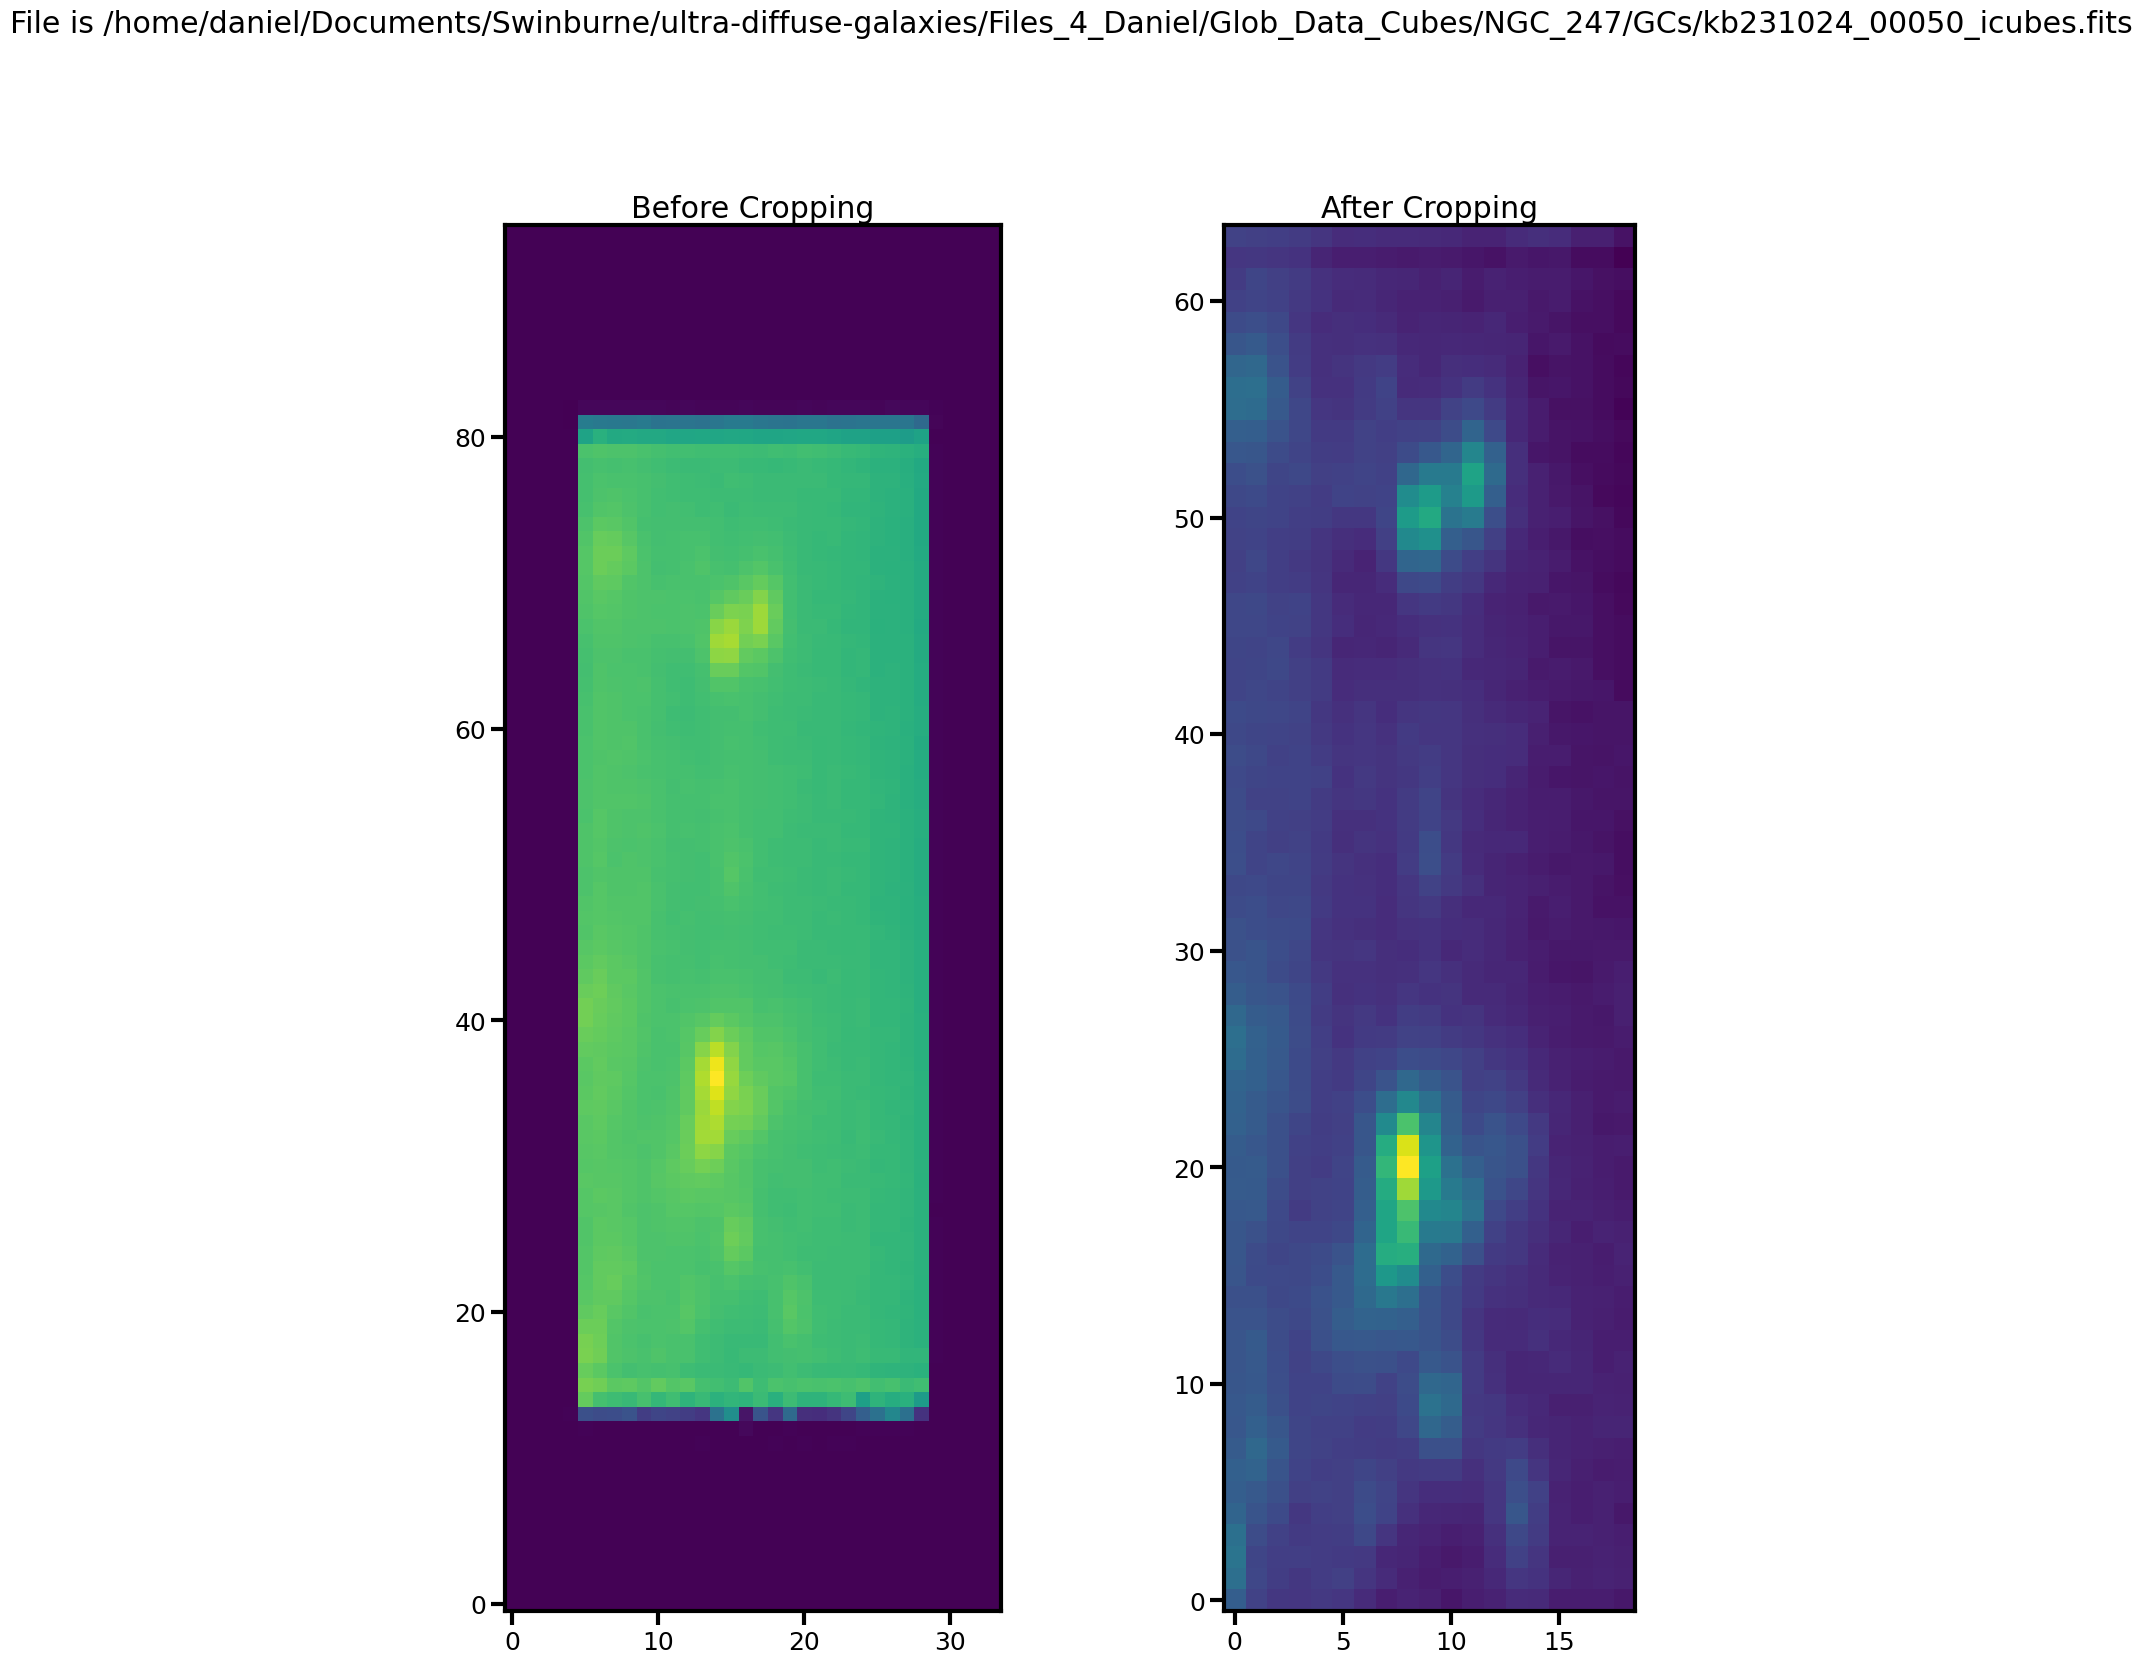

Files Written out


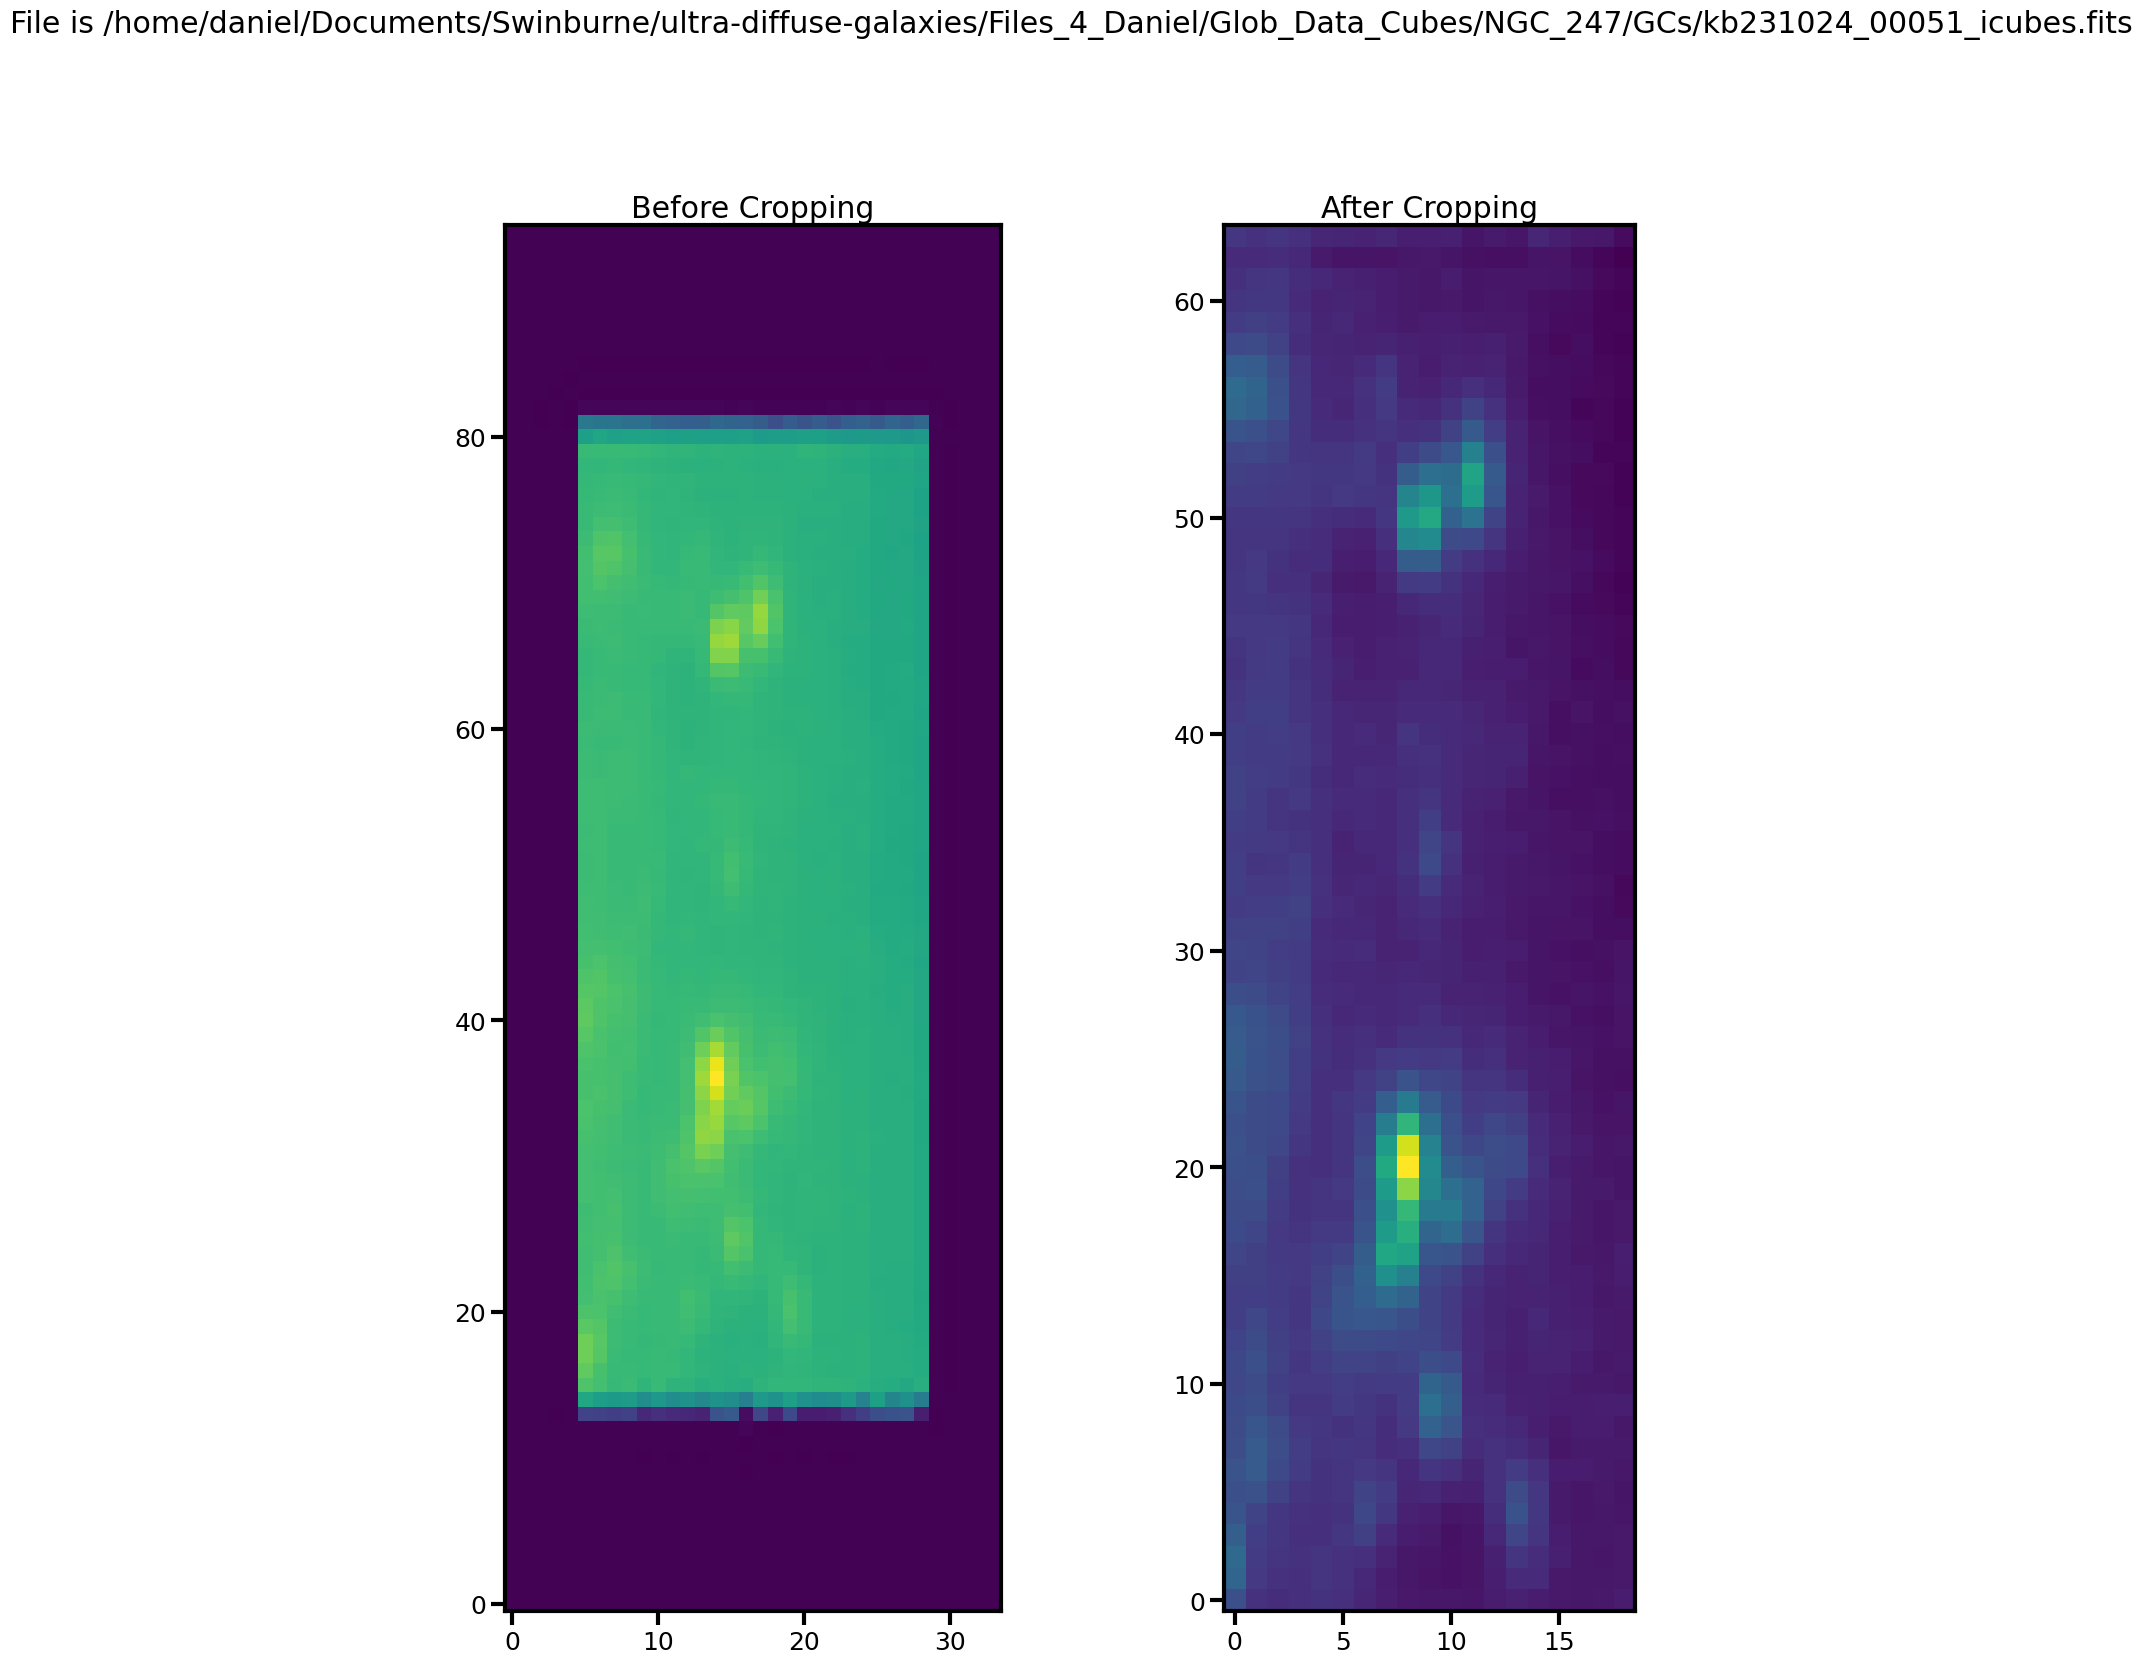

Files Written out


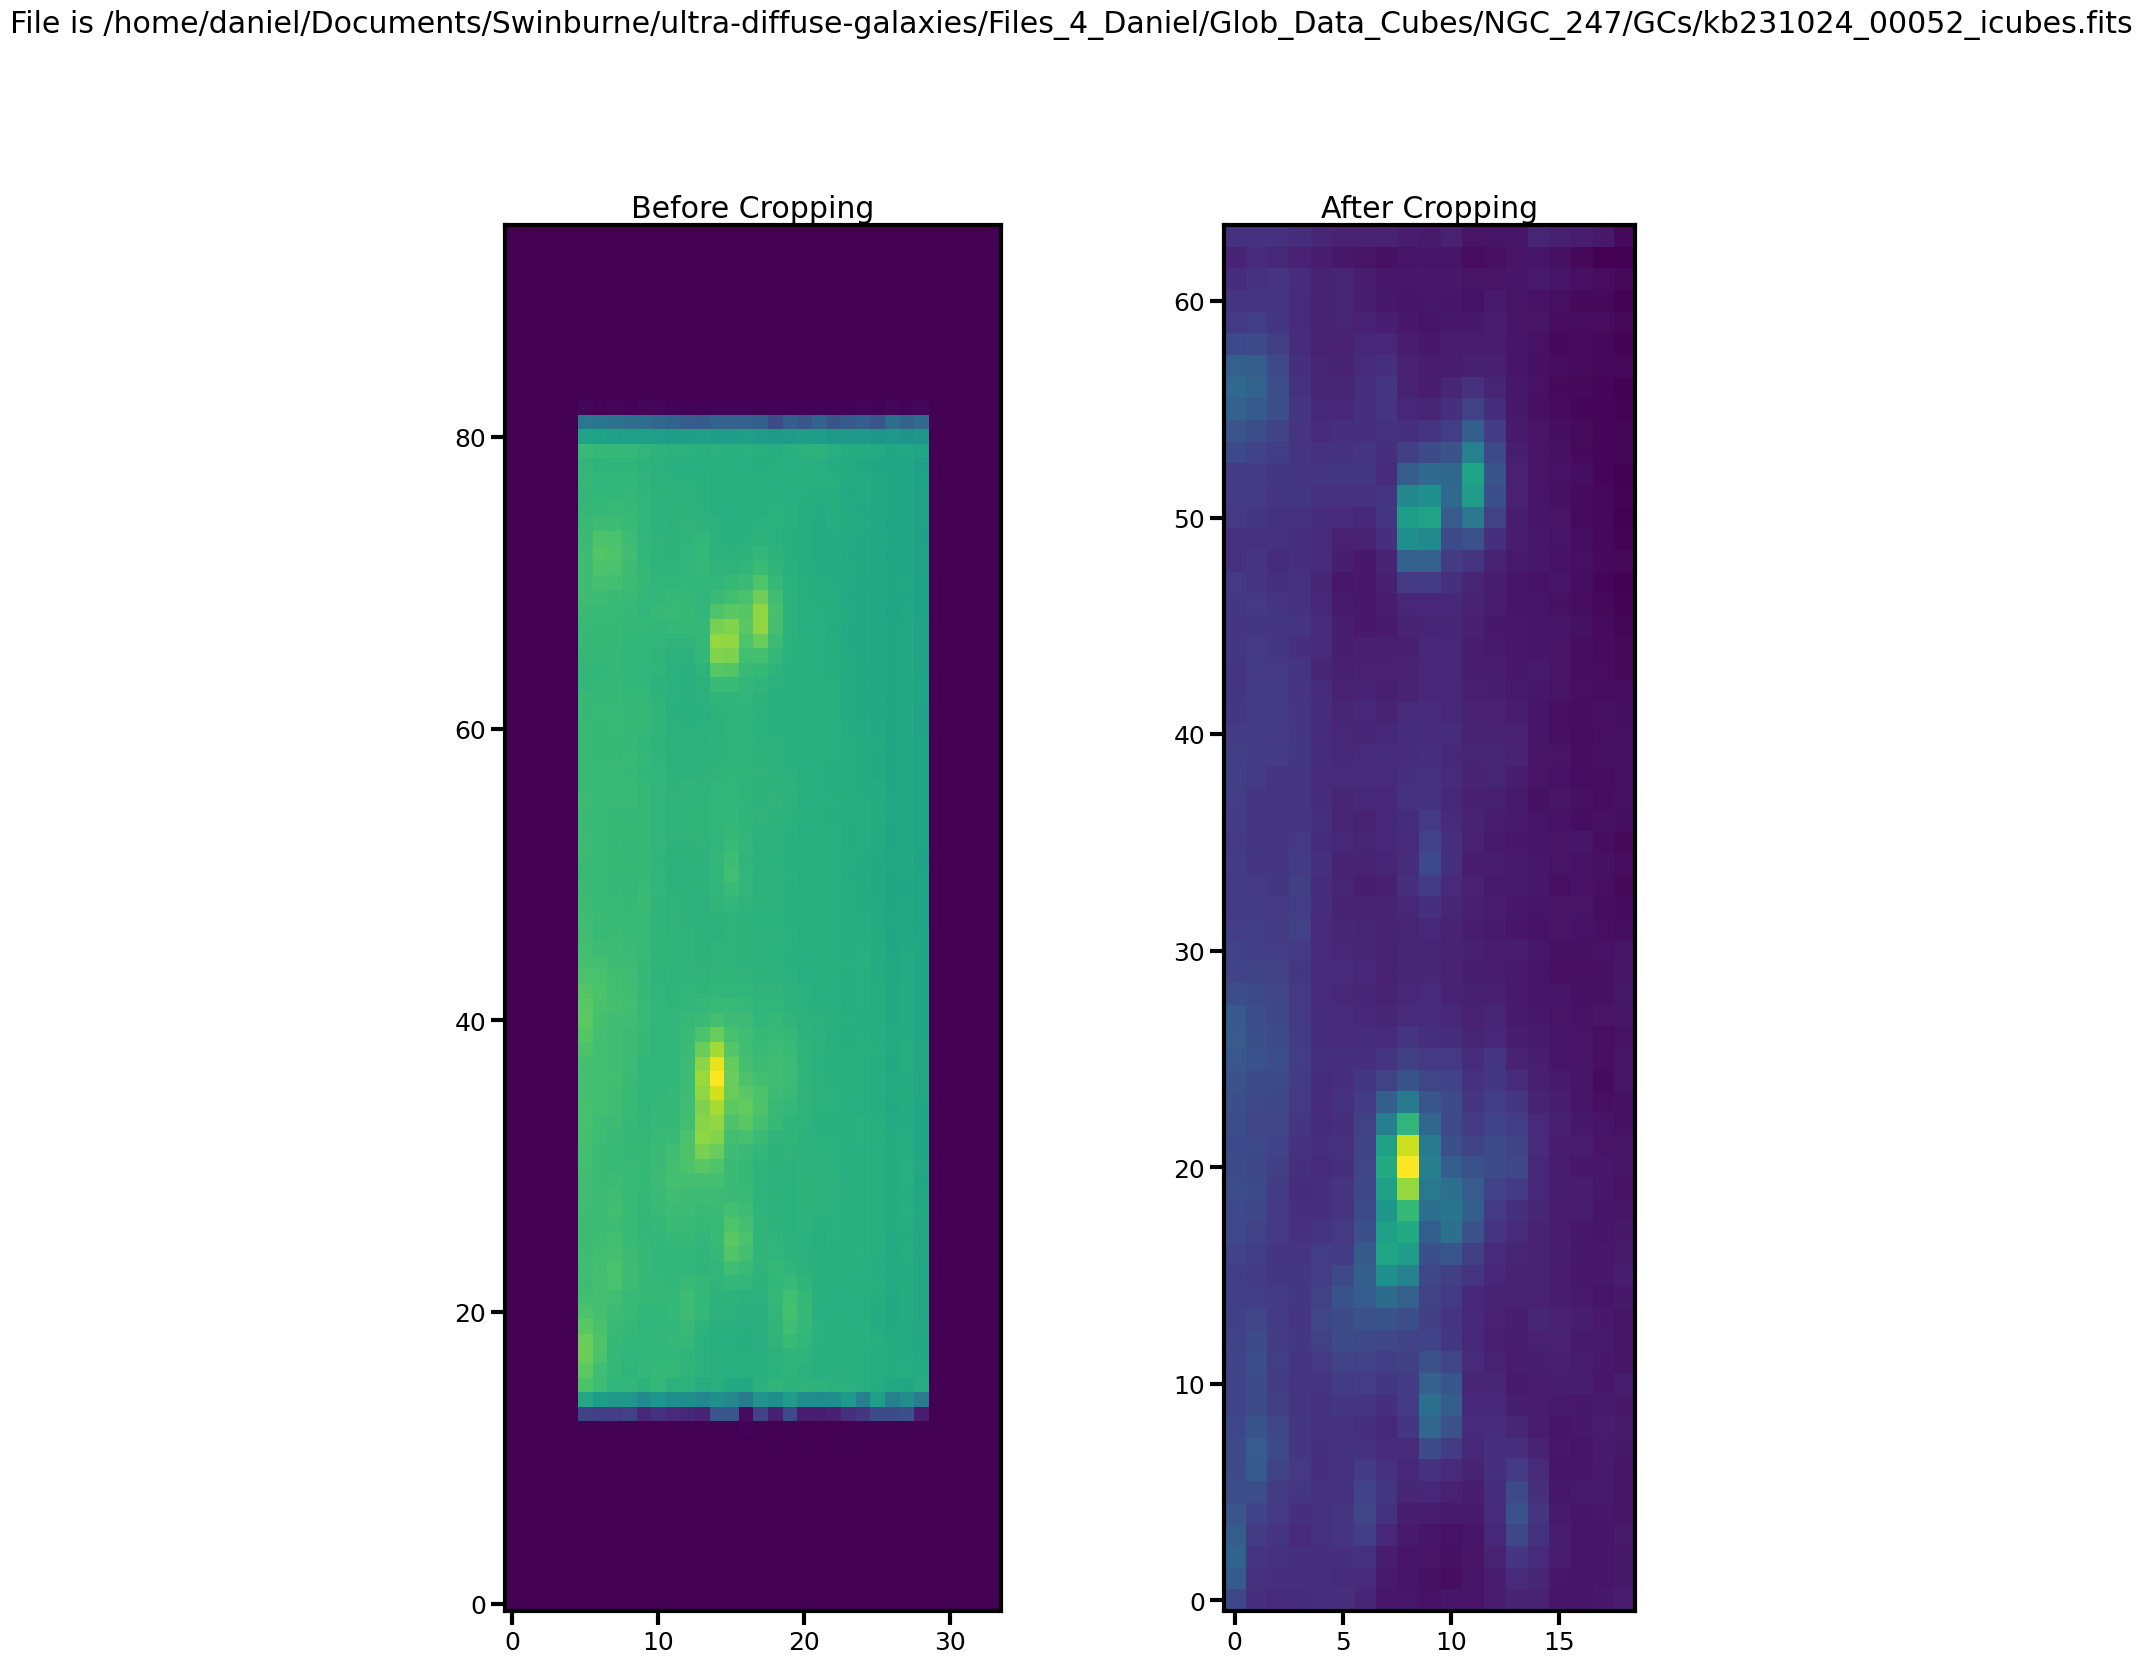

Files Written out
Code Competed Successfully in, 82.24 seconds


In [4]:
s1_file_directory = '/home/daniel/Documents/Swinburne/ultra-diffuse-galaxies/Files_4_Daniel/Glob_Data_Cubes/NGC_247/GCs/' # path to directory containing spectra
s1_file_keyword = '*kb*icubes*' # keyword to find files in directory

x_low = 7 # lowest and highest xvalue of the spaxel to be INCLUDED in the rectangle
x_high = 25
y_low = 17 # lowest and highest yvalue of the spaxel to be INCLUDED in the rectangle
y_high = 80

cut_cube(s1_file_directory, s1_file_keyword, x_low, x_high, y_low, y_high)

### 2) Extract spectra

Get spectra of the desired objects

1) Open each cut file in QFitsView and place your desired aperture and annulus. 

2) Right click the object and choosing "Copy spectrum to new buffer" 

3) Then right click again and choose "Save spectrum as fits"

4) Repeat for each object.

5) Repeat for each file

### 3) Barycentric correction

1) Input file and keyword to select extracted spectra

2) Set to "manual" and choose your own correction \
OR \
set to "auto" and get the automatic correction

In [5]:
s2_file_directory = '/home/daniel/Documents/Swinburne/ultra-diffuse-galaxies/results_GC/NGC_247/GCs/obj1/' # path to directory containing spectra
s2_file_keyword = '[0-9]*.fits' # keyword to find files in directory
corrections = 'auto' # 'manual' or else 'automatic'

# ------------------------------

if corrections == 'manual':
    bary_corr = np.array([0,0,0]) # Manual barycentric correction in km/s. One number for each file!
    # INPUT MANUAL ABOVE ^^^^^^
elif corrections == 'auto':
    bary_corr = barycentric_correction(s2_file_directory, s2_file_keyword)
    bary_corr = np.array(bary_corr)
    if np.all(bary_corr > 0):
        bary_corr = -bary_corr
        print('ensured bary_corr is negative')
    
print(f'Barycentric correction: {bary_corr} km/s')
print(f'Correction Deltas: {np.diff(bary_corr)} km/s')
plt.close()

The Barycentric correction is: 15.475628058216078 km/s
The Barycentric correction is: 15.527670849695077 km/s
The Barycentric correction is: 15.578652874996106 km/s
ensured bary_corr is negative
Barycentric correction: [-15.47562806 -15.52767085 -15.57865287] km/s
Correction Deltas: [-0.05204279 -0.05098203] km/s


### 4) Spectra Stacking

Stacks all files from a single object together. If multiple objects exist, you must rerun step 3) for each object

list of files: ['/home/daniel/Documents/Swinburne/ultra-diffuse-galaxies/results_GC/NGC_247/GCs/obj1/50.fits', '/home/daniel/Documents/Swinburne/ultra-diffuse-galaxies/results_GC/NGC_247/GCs/obj1/51.fits', '/home/daniel/Documents/Swinburne/ultra-diffuse-galaxies/results_GC/NGC_247/GCs/obj1/52.fits']
[3632. 3633. 3634. ... 5622. 5623. 5624.]


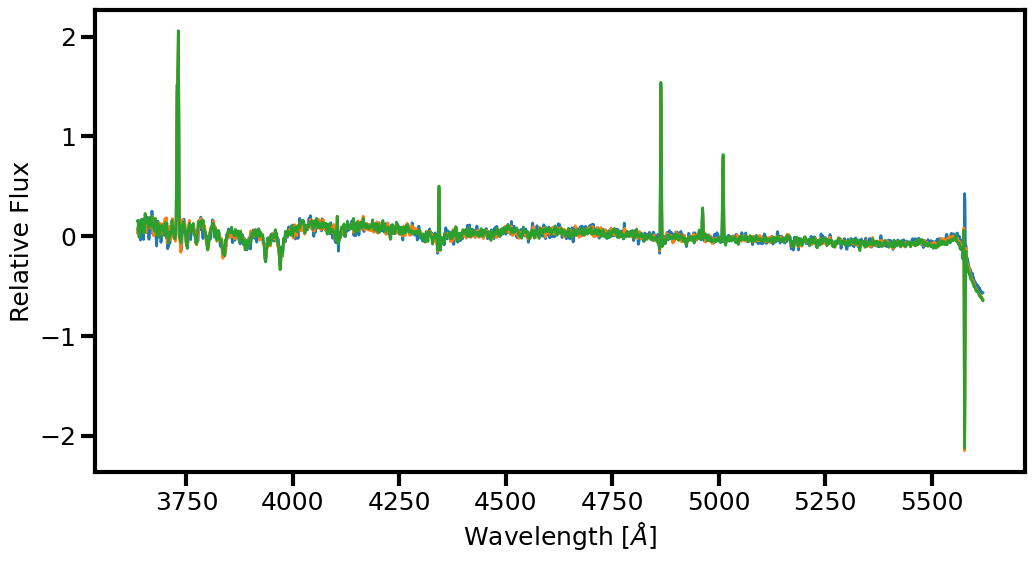

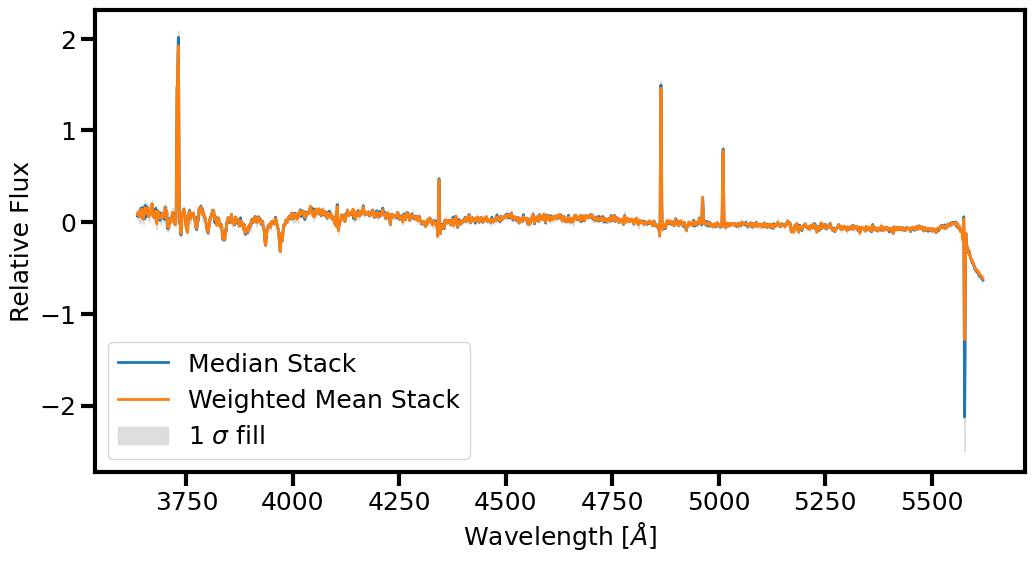

OSError: File '/home/daniel/Documents/Swinburne/ultra-diffuse-galaxies/results_GC/NGC_247/GCs/obj1/mean.fits' already exists.

In [6]:
overwrite = False # if True, will overwrite any existing files. Proceed with caution.

spectra_stack(s2_file_directory, s2_file_keyword, bary_corr, overwrite)

### Setup pPXF

In [3]:
# Input parameters
stacked_file = '/home/daniel/Documents/Swinburne/ultra-diffuse-galaxies/results_GC/NGC_247/GCs/obj1/mean_NCS.fits' # path to stacked spectra
zi = 0.00052 #redshift guess
FWHM_data = 4550 / 1800 # data resolution
vel_start = 156 # velocity estimate
sigma_start = 80 # velocity dispersion estimate
wave_min = 3600 # minimum wavelength to fit
wave_max = 5400 # maximum wavelength to fit
region = "default" # define a region to fit (default/all/no_mgb/blue/red/before_mgb/lt5100)

# ----------------------------------------------------------------------------------------------
# Dont touch below here in this code block
# ----------------------------------------------------------------------------------------------

c = 299792.458  # speed of light in km/s
sps_name = 'emiles'
redshift_0 = 0

# Extract the wavelength range
hdu = fits.open(stacked_file)
data = hdu[0].data
header = hdu[0].header
wave = header['CRVAL1'] + (np.arange(0, header['NAXIS1']) - 1) * header['CDELT1']
mask = (wave > wave_min) & (wave < wave_max)
wave = wave[mask]

# Set up the galaxy and the template stars
galaxy, ln_lam1, velscale = ppxf_util.log_rebin(wave, data[mask])
galaxy = galaxy/np.median(galaxy)  # Normalize spectrum to avoid numerical issues
noise = np.full_like(galaxy, 0.0163)  # Assume constant noise per pixel here

# Get templates
basename = f"spectra_{sps_name}_9.0.npz"
ppxf_dir = path.dirname(path.realpath(ppxf_util.__file__))
filename = path.join(ppxf_dir, 'sps_models', basename)
sps = sps_util.sps_lib(filename, velscale, wave_range=[wave_min, wave_max])

# Initial guess of the kinematics
# vel_start = c*np.log(1 + zi)
# sigma_start = 3*velscale
moments = 2
start = [vel_start, sigma_start]

# 
lamRangeTemp = np.exp(np.array([np.min(sps.ln_lam_temp), np.max(sps.ln_lam_temp)]))

# Choose the wavelength range and the pixels to mask
if region == 'all':
    goodPixels = np.arange(0, len(galaxy), 1) # all
elif region == "all_minus_10":
    goodPixels = np.arange(10, len(galaxy)-10, 1) # all
elif region == 'default':
    goodPixels = ppxf_util.determine_goodpixels(ln_lam1, lamRangeTemp, zi)
elif region == 'no_mgb':
    goodPixels = np.hstack((np.arange(0, 1430, 1), np.arange(1550, len(galaxy), 1)))
elif region == 'blue':
    goodPixels = np.arange(0, round(len(galaxy)/2), 1)
elif region == 'red':
    goodPixels = np.arange(round(len(galaxy)/2), len(galaxy)-25, 1)
elif region == 'before_mgb':
    goodPixels = np.arange(0, 1410, 1)
elif region == 'no_starting_hbeta':
    goodPixels = np.arange(175, len(galaxy), 1)
elif region == 'leo':
    goodPixels = np.arange(150, len(galaxy), 1)
elif region == 'lt5100':
    goodPixels = np.arange(0, 1128, 1)
elif region == 'lt5100-leo':
    goodPixels = np.arange(0, 1103, 1)
else:
    raise Exception("Define a fitting region!")

### 5) Check Kinematic Degree

Run as is

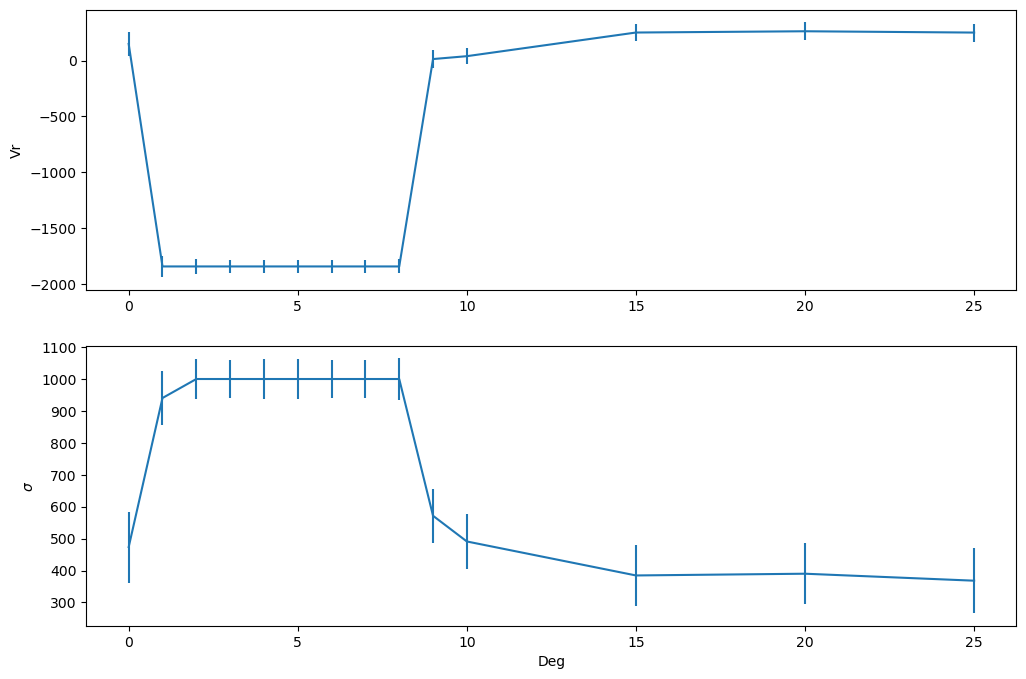

In [4]:
deg_kinem = np.asarray([0,1,2,3,4,5,6,7,8,9,10,15,20,25])  #series of degrees to check

def process_deg_kinem(i):   
    pp = ppxf(sps.templates, galaxy, noise, velscale, start,
        goodpixels=goodPixels, plot=True, 
        moments=moments, degree=i, mdegree=-1,
        lam=np.exp(ln_lam1),
        component=0)

    vr = pp.sol[0]
    evr = pp.error[0] * np.sqrt(pp.chi2)
    sig = pp.sol[1]
    esig = pp.error[1] * np.sqrt(pp.chi2)
    return vr, evr, sig, esig

def run_deg_kinem(deg_kinem):
    results = []
    with Pool() as pool:
        for result in pool.imap(process_deg_kinem, range(len(deg_kinem))):
            results.append(result)
    
    vr = [result[0] for result in results]
    evr = [result[1] for result in results]
    sig = [result[2] for result in results]
    esig = [result[3] for result in results]
    return vr, evr, sig, esig

vr, evr, sig, esig = run_deg_kinem(deg_kinem)

clear_output()

fig = plt.figure(1, figsize=(12, 8))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

ax1.errorbar(deg_kinem, vr, yerr=evr)
ax1.set_ylabel("Vr")

ax2.errorbar(deg_kinem, sig, yerr=esig)
ax2.set_ylabel("$\sigma$")
ax2.set_xlabel("Deg")
plt.show()

### 6)pPXF Best Fit

 Best Fit:       Vel     sigma
 comp.  0:        41       491
chi2/DOF: 11.11; DOF: 1606; degree = 10; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/150
Formal errors:
     dV    dsigma   dh3      dh4
      74      85
Elapsed time in pPXF: 0.19 s
Best-fitting redshift z = 0.00014 +/- 0.00025
Signal-to-noise ratio per pixel: 3.94
0.20608779314002446 [0.0163 0.0163 0.0163 ... 0.0163 0.0163 0.0163]


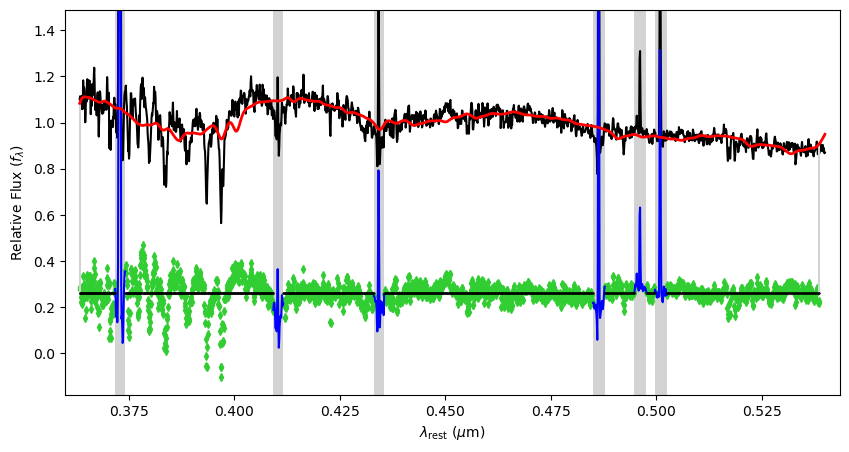

In [5]:
deg_k = 10
deg_p = -1

t = perf_counter()
plt.figure(figsize=(10,5))
pp = ppxf(sps.templates, galaxy, noise, velscale, start,
    goodpixels=goodPixels, plot=True, 
    moments=moments, degree=deg_k, mdegree=deg_p,
    lam=np.exp(ln_lam1),
    component=0)

residuals = galaxy[:len(goodPixels)] - pp.bestfit[:len(goodPixels)]
signal = np.median((pp.bestfit[:len(goodPixels)] - pp.apoly[:len(goodPixels)]))#/pp1.mpoly)
noise2 = np.std(residuals[residuals<np.percentile(residuals, 90)])

SN_ratio = signal / noise2

# The updated best-fitting redshift is given by the following
# lines (using equations 5 of Cappellari 2022, arXiv, C22)
errors = pp.error*np.sqrt(pp.chi2)  # Assume the fit is good chi2/DOF=1
redshift_fit = (1 + redshift_0)*np.exp(pp.sol[0]/c) - 1  # eq. (5c) C22
redshift_err = (1 + redshift_fit)*errors[0]/c            # eq. (5d) C22

print("Formal errors:")
print("     dV    dsigma   dh3      dh4")
print("".join("%8.2g" % f for f in errors))
print('Elapsed time in pPXF: %.2f s' % (perf_counter() - t))
prec = int(1 - np.floor(np.log10(redshift_err)))  # two digits of uncertainty
print(f"Best-fitting redshift z = {redshift_fit:#.{prec}f} "
        f"+/- {redshift_err:#.{prec}f}")
print(f"Signal-to-noise ratio per pixel: {SN_ratio:.2f}")
print(signal, noise)

plt.show()

# """ User inputs """
# degree = 4 # degree of Legendre polynomial to use

# plt.close()
# plt.figure(figsize=(10,5))
# ppxf_kinematics(ppxf_file, fwhm_gal, degree, wav_min, wav_max, fit='all', mdegree=4)
# # plt.savefig(os.path.dirname(ppxf_file) + '/fit.png')